# Image-Text Semantic Matching with AutoMM
:label:`image_text_matching`

[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/neurips2022-autogluon-workshop/blob/main/notebooks/multimodal/image_text_matching.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/neurips2022-autogluon-workshop/blob/main/notebooks/multimodal/image_text_matching.ipynb)

Vision and language are two important aspects of human intelligence to understand the real world. Image-text semantic matching, measuring the visual-semantic
similarity between image and text, plays a critical role in bridging the vision and language. 
Learning a joint space where text
and image feature vectors are aligned is a typical solution for image-text matching. It is becoming increasingly significant for various vision-and-language tasks,
such as cross-modal retrieval, image
captioning, text-to-image synthesis, and multimodal neural machine translation. This tutorial will introduce how to apply AutoMM to the image-text matching task.

To start, let's install autogluon and import MultiModalPredictor. Note that you will **have to restart the runtime** if you are using Google Colab / SageMaker Studio Lab.

In [1]:
!pip install -q autogluon
!mim install -q mmcv-full
!pip install -q mmdet

In [2]:
import os
import warnings
from IPython.display import Image, display
import numpy as np
warnings.filterwarnings('ignore')
np.random.seed(123)

## Dataset

In this tutorial, we will use the Flickr30K dataset to demonstrate the image-text matching.
The Flickr30k dataset is a popular benchmark for sentence-based picture portrayal. The dataset is comprised of 31,783 images that capture people engaged in everyday activities and events. Each image has a descriptive caption. We organized the dataset using pandas dataframe. To get started, Let's download the dataset.

In [3]:
from autogluon.core.utils.loaders import load_pd
import pandas as pd
download_dir = './ag_automm_tutorial_imgtxt'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/flickr30k.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

100%|██████████| 4.38G/4.38G [05:38<00:00, 12.9MiB/s]


Then we will load the csv files.

In [4]:
dataset_path = os.path.join(download_dir, 'flickr30k_processed')
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
val_data = pd.read_csv(f'{dataset_path}/val.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
image_col = "image"
text_col = "caption"

We also need to expand the relative image paths to use their absolute local paths.

In [5]:
def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
val_data[image_col] = val_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

Take `train_data` for example, let's see how the data look like in the dataframe.

In [6]:
train_data.head()

,caption,image
0,Two young guys with shaggy hair look at their ...,/content/ag_automm_tutorial_imgtxt/flickr30k_p...
1,Two young White males are outside near many bu...,/content/ag_automm_tutorial_imgtxt/flickr30k_p...
2,Two men in green shirts are standing in a yard,/content/ag_automm_tutorial_imgtxt/flickr30k_p...
3,A man in a blue shirt standing in a garden,/content/ag_automm_tutorial_imgtxt/flickr30k_p...
4,Two friends enjoy time spent together,/content/ag_automm_tutorial_imgtxt/flickr30k_p...


Each row is one image and text pair, implying that they match each other. Since one image corresponds to five captions in the dataset, we copy each image path five times to build the correspondences. We can visualize one image-text pair.

In [7]:
train_data[text_col][0]

'Two young guys with shaggy hair look at their hands while hanging out in the yard'

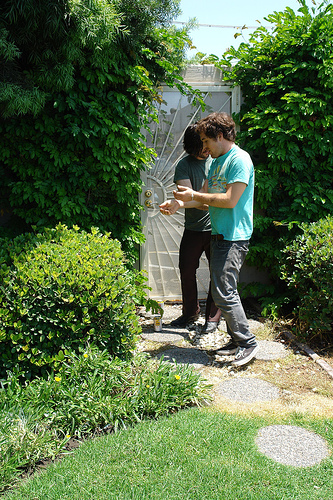

In [8]:
pil_img = Image(filename=train_data[image_col][0])
display(pil_img)

To perform evaluation or semantic search, we need to extract the unique image and text items from `text_data` and add one label column in the `test_data`.

In [9]:
test_image_data = pd.DataFrame({image_col: test_data[image_col].unique().tolist()})
test_text_data = pd.DataFrame({text_col: test_data[text_col].unique().tolist()})
test_data_with_label = test_data.copy()
test_label_col = "relevance"
test_data_with_label[test_label_col] = [1] * len(test_data)

## Initialize Predictor
To initialize a predictor for image-text matching, we need to set `problem_type` as `image_text_similarity`. `query` and `response` refer to the two dataframe columns in which two items in one row should match each other. You can set `query=text_col` and `response=image_col`, or `query=image_col` and `response=text_col`. In image-text matching, `query` and `response` are equivalent.

In [10]:
from autogluon.multimodal import MultiModalPredictor
predictor = MultiModalPredictor(
            query=text_col,
            response=image_col,
            problem_type="image_text_similarity",
            eval_metric="recall",
        )

Downloading:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/862k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

By initializing the predictor for `image_text_similarity`, you have loaded the pretrained CLIP backbone `openai/clip-vit-base-patch32`.

## Directly Evaluate on Test Dataset (Zero-shot)
You may be interested in getting the pretrained model's performance on your data. Let's compute the text-to-image and image-to-text retrieval scores.

In [11]:
txt_to_img_scores = predictor.evaluate(
            data=test_data_with_label,
            query_data=test_text_data,
            response_data=test_image_data,
            label=test_label_col,
            cutoffs=[1, 5, 10],
        )
img_to_txt_scores = predictor.evaluate(
            data=test_data_with_label,
            query_data=test_image_data,
            response_data=test_text_data,
            label=test_label_col,
            cutoffs=[1, 5, 10],
        )
print(f"txt_to_img_scores: {txt_to_img_scores}")
print(f"img_to_txt_scores: {img_to_txt_scores}")

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

txt_to_img_scores: {'recall@1': 0.58964, 'recall@5': 0.83533, 'recall@10': 0.90156}
img_to_txt_scores: {'recall@1': 0.15525, 'recall@5': 0.5708, 'recall@10': 0.7172}


Here we report the `recall`, which is the `eval_metric` in intializing the predictor above. One `cutoff` value means using the top k retrieved items to calculate the score. You may find that the text-to-image recalls are much higher than the image-to-text recalls. This is because each image is paired with five texts. In image-to-text retrieval, the upper bound of `recall@1` is 20%, which means that the top-1 text is correct, but there are totally five texts to retrieve.

## Finetune Predictor
After measuring the pretrained performance, we can finetune the model on our dataset to see whether we can get improvements. For a quick demo, here we set the time limit to 180 seconds.

In [12]:
predictor.fit(
            train_data=train_data,
            tuning_data=val_data,
            time_limit=180,
        )

INFO:pytorch_lightning.utilities.seed:Global seed set to 123
INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                      | Params
----------------------------------------------------------------
0 | query_model       | CLIPForImageText          | 151 M 
1 | response_model    | CLIPForImageText          | 151 M 
2 | validation_metric | CustomHitRate             | 0     
3 |

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Time limit reached. Elapsed time is 0:03:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 148: 'val_hit_rate' reached 3.25562 (best 3.25562), saving model to '/content/AutogluonModels/ag-20221128_083850/epoch=0-step=148.ckpt' as top 3
INFO:automm:Start to fuse 1 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:automm:Models and intermediate outputs are saved to /content/AutogluonModels/ag-20221128_083850 


## Evaluate the Finetuned Model on the Test Dataset
Now Let's evaluate the finetuned model. Similarly, we also compute the recalls of text-to-image and image-to-text retrievals.

In [13]:
txt_to_img_scores = predictor.evaluate(
            data=test_data_with_label,
            query_data=test_text_data,
            response_data=test_image_data,
            label=test_label_col,
            cutoffs=[1, 5, 10],
        )
img_to_txt_scores = predictor.evaluate(
            data=test_data_with_label,
            query_data=test_image_data,
            response_data=test_text_data,
            label=test_label_col,
            cutoffs=[1, 5, 10],
        )
print(f"txt_to_img_scores: {txt_to_img_scores}")
print(f"img_to_txt_scores: {img_to_txt_scores}")

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

txt_to_img_scores: {'recall@1': 0.67227, 'recall@5': 0.88876, 'recall@10': 0.94128}
img_to_txt_scores: {'recall@1': 0.16325, 'recall@5': 0.6468, 'recall@10': 0.793}


We can observe large improvements over the zero-shot predictor. This means that finetuning CLIP on our customized data may help achieve better performance.

## Predict Whether Image and Text Match
Whether finetuned or not, the predictor can predict whether image and text pairs match.

In [14]:
pred = predictor.predict(test_data.head(5))
print(pred)

Predicting: 0it [00:00, ?it/s]

0    1
1    1
2    1
3    1
4    1
dtype: int64


## Predict Matching Probabilities
The predictor can also return to you the matching probabilities.

In [15]:
proba = predictor.predict_proba(test_data.head(5))
print(proba)

Predicting: 0it [00:00, ?it/s]

          0         1
0  0.348157  0.651843
1  0.325334  0.674666
2  0.350774  0.649226
3  0.347930  0.652070
4  0.334178  0.665822


The second column is the probability of being a match.

## Extract Embeddings
Another common user case is to extract image and text embeddings.

In [16]:
image_embeddings = predictor.extract_embedding({image_col: test_image_data[image_col][:5].tolist()})
print(image_embeddings.shape) 

Predicting: 0it [00:00, ?it/s]

(5, 512)


In [17]:
text_embeddings = predictor.extract_embedding({text_col: test_text_data[text_col][:5].tolist()})
print(text_embeddings.shape)

Predicting: 0it [00:00, ?it/s]

(5, 512)


## Semantic Search
We also provide an advanced util function to conduct semantic search. First, given one or more texts, we can search semantically similar images from an image database.

In [18]:
from autogluon.multimodal.utils import semantic_search
text_to_image_hits = semantic_search(
        matcher=predictor,
        query_data=test_text_data.iloc[[3]],
        response_data=test_image_data,
        top_k=5,
    )

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Let's visualize the text query and top-1 image response.

In [19]:
test_text_data.iloc[[3]]

,caption
3,A man in an orange hat starring at something


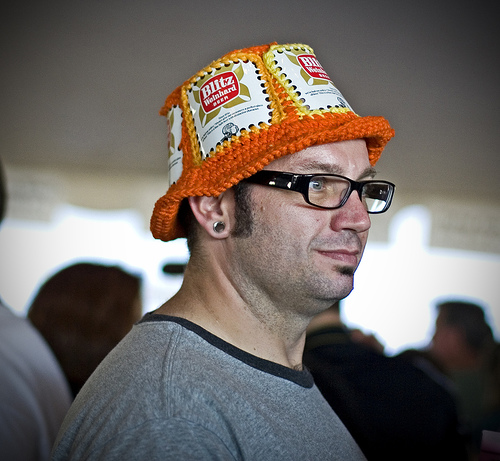

In [20]:
pil_img = Image(filename=test_image_data[image_col][text_to_image_hits[0][0]['response_id']])
display(pil_img)

Similarly, given one or more images, we can retrieve texts with similar semantic meanings.

In [21]:
image_to_text_hits = semantic_search(
        matcher=predictor,
        query_data=test_image_data.iloc[[6]],
        response_data=test_text_data,
        top_k=5,
    )

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Let's visualize the image query and top-1 text response.

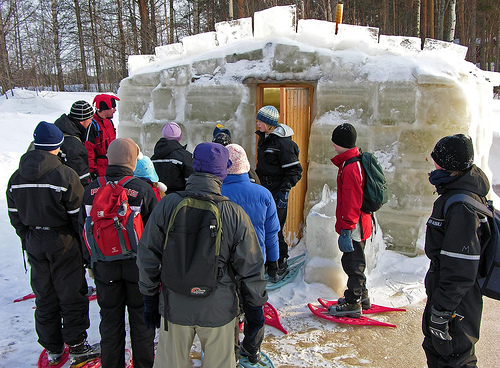

In [22]:
pil_img = Image(filename=test_image_data[image_col][6])
display(pil_img)

In [23]:
test_text_data[text_col][image_to_text_hits[0][1]['response_id']]

'Several students waiting outside an igloo'

## Other Examples

You may go to [AutoMM Examples](https://github.com/awslabs/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.


## Customization

To learn how to customize AutoMM, please refer to [customization tutorial](https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html).